# **DeepPredictor – Classificação de Cobertura Florestal com MLP**

Integrantes da Equipe:
- AYANNE ALMEIDA
- JOSÉ ALBERTO
- CARLOS ALBERTO
- PETRÔNIO DA SILVA

Contexto:

 As florestas são biomas importantes para a preservação do planeta, mas com os distúrbios climáticos causados pela ação humana cada vez mais se tem percebido a degradação florestal. Este trabalho objetiva produzir uma MLP que auxilie na previsão do tipo de cobertura florestal apenas a partir de variáveis cartográficas (sem dados de sensoriamento remoto) a qual, em conjunto com outras redes neurais, possibilite reconhecer mudanças significativas nos ambientes florestais por meio de imagens dos locais monitorados.

 Este projeto implementa uma MLP para classificação de pixels em 7 tipos de cobertura florestal com base em atributos como elevação, aspecto, declive, sombreamento, tipo de solo entre outros, explorando diferentes arquiteturas e hiperparâmetros.

# **Instalando as biblotecas necessárias e entendendo a base de dados**

In [ ]:
# Instalar pacotes necessários para facilitar o dowload de bases do UCI
!pip install ucirepo scikit-learn tensorflow matplotlib seaborn --quiet

# 1. Carregamento e exploração inicial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from ucimlrepo import fetch_ucirepo

# Carregar o dataset
cov = fetch_ucirepo(id=31)  #31 corresponde à Forest CoverType
df  = cov.data.features.copy()
df['Cover_Type'] = cov.data.targets.values  # adiciona a coluna-alvo ao DataFrame

# Dicionário de tradução para nomes de colunas (variáveis contínuas)
colunas_traducao = {
    'Elevation': 'Elevacao',
    'Aspect': 'Orientacao',
    'Slope': 'Declinacao',
    'Horizontal_Distance_To_Hydrology': 'Dist_Horiz_Hidrologia',
    'Vertical_Distance_To_Hydrology': 'Dist_Vert_Hidrologia',
    'Horizontal_Distance_To_Roadways': 'Dist_Horiz_Estradas',
    'Hillshade_9am': 'Sombreamento_9h',
    'Hillshade_Noon': 'Sombreamento_12h',
    'Hillshade_3pm': 'Sombreamento_15h',
    'Horizontal_Distance_To_Fire_Points': 'Dist_Horiz_Pontos_Fogo'
}

colunas_traducao.update({f'Wilderness_Area_{i}': f'Area_Selvagem_{i}' for i in range(1, 5)})
# Soil_Type_1..40 -> Tipo_Solo_1..40
colunas_traducao.update({f'Soil_Type_{i}': f'Tipo_Solo_{i}' for i in range(1, 41)})

# Aplicar a renomeação
df.rename(columns=colunas_traducao, inplace=True)

# Traduzir os rótulos das classes (1–7) para nomes de cobertura florestal em português
mapeamento_cover = {
    1: 'Abeto/Picea (Spruce/Fir)',
    2: 'Pinheiro Lodgepole',
    3: 'Pinheiro Ponderosa',
    4: 'Choupo/Salgueiro',
    5: 'Álamo/Tremendo (Aspen)',
    6: 'Pinheiro-de-Douglas',
    7: 'Krummholz (vegetação rasteira alpina)'
}
df['Cover_Type'] = df['Cover_Type'].map(mapeamento_cover)

# Verificar o resultado
display(df.head())

# Contagem por tipo de cobertura
display(df['Cover_Type'].value_counts())

# Obter informações sobre tipos de dados e ausências
df.info()

# Exibir estatísticas descritivas das variáveis contínuas (agora renomeadas)
cont_cols = ['Elevacao','Orientacao','Declinacao','Dist_Horiz_Hidrologia',
             'Dist_Vert_Hidrologia','Dist_Horiz_Estradas',
             'Sombreamento_9h','Sombreamento_12h','Sombreamento_15h',
             'Dist_Horiz_Pontos_Fogo']
display(df[cont_cols].describe())

ERROR: Could not find a version that satisfies the requirement ucirepo (from versions: none)
ERROR: No matching distribution found for ucirepo


,Elevacao,Orientacao,Declinacao,Dist_Horiz_Hidrologia,Dist_Vert_Hidrologia,Dist_Horiz_Estradas,Sombreamento_9h,Sombreamento_12h,Sombreamento_15h,Dist_Horiz_Pontos_Fogo,...,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,Álamo/Tremendo (Aspen)
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,Álamo/Tremendo (Aspen)
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,Pinheiro Lodgepole
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,Pinheiro Lodgepole
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,Álamo/Tremendo (Aspen)


,count
Cover_Type,
Pinheiro Lodgepole,283301
Abeto/Picea (Spruce/Fir),211840
Pinheiro Ponderosa,35754
Krummholz (vegetação rasteira alpina),20510
Pinheiro-de-Douglas,17367
Álamo/Tremendo (Aspen),9493
Choupo/Salgueiro,2747


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Elevacao                581012 non-null  int64 
 1   Orientacao              581012 non-null  int64 
 2   Declinacao              581012 non-null  int64 
 3   Dist_Horiz_Hidrologia   581012 non-null  int64 
 4   Dist_Vert_Hidrologia    581012 non-null  int64 
 5   Dist_Horiz_Estradas     581012 non-null  int64 
 6   Sombreamento_9h         581012 non-null  int64 
 7   Sombreamento_12h        581012 non-null  int64 
 8   Sombreamento_15h        581012 non-null  int64 
 9   Dist_Horiz_Pontos_Fogo  581012 non-null  int64 
 10  Wilderness_Area1        581012 non-null  int64 
 11  Soil_Type1              581012 non-null  int64 
 12  Soil_Type2              581012 non-null  int64 
 13  Soil_Type3              581012 non-null  int64 
 14  Soil_Type4              581012 non-n

,Elevacao,Orientacao,Declinacao,Dist_Horiz_Hidrologia,Dist_Vert_Hidrologia,Dist_Horiz_Estradas,Sombreamento_9h,Sombreamento_12h,Sombreamento_15h,Dist_Horiz_Pontos_Fogo
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


from matplotlib import pyplot as plt
_df_0['Elevacao'].plot(kind='hist', bins=20, title='Elevacao')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Orientacao'].plot(kind='hist', bins=20, title='Orientacao')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Declinacao'].plot(kind='hist', bins=20, title='Declinacao')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Dist_Horiz_Hidrologia'].plot(kind='hist', bins=20, title='Dist_Horiz_Hidrologia')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Elevacao', y='Orientacao', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Orientacao', y='Declinacao', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Declinacao', y='Dist_Horiz_Hidrologia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Dist_Horiz_Hidrologia', y='Dist_Vert_Hidrologia', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Elevacao'].plot(kind='line', figsize=(8, 4), title='Elevacao')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Orientacao'].plot(kind='line', figsize=(8, 4), title='Orientacao')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Declinacao'].plot(kind='line', figsize=(8, 4), title='Declinacao')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Dist_Horiz_Hidrologia'].plot(kind='line', figsize=(8, 4), title='Dist_Horiz_Hidrologia')
plt.gca().spines[['top', 'right']].set_visible(False)

A origem da base de dados:

 -O Forest CoverType é uma base pública do UCI KDD Archive contendo 581.012 instâncias e 54 atributos

 -Não há dados ausentes.

 -Cada instância corresponde a um pixel de 30m X 30m da Floresta Nacional Roosevelt (EUA)

 -São 7 os tipos de cobertura florestal (Spruce/Fir, LodgepolePine, PonderosaPine, Cottonwood/Willow, Aspen, Douglas-fir e Krummholz)

 -As variáveis independentes incluem 10 variáveis quantitativas (por exemplo, elevação, declive, distâncias horizontais/verticais a hidrografia e estradas, índices de sombreamento) e 44 variáveis binárias representando a área selvagem (4 colunas) e o tipo de solo (40 colunas)


IMPORTANTE: A distribuição das classes é desbalanceada: por exemplo, há 283.301 registros de Lodgepole Pine e apenas 2.747 de Cottonwood/Willow. Isso pode influenciar as métricas de desempenho justificando, inclusive, o uso de métricas como precisão, recall e F1-score.

## **Pré-processamento**

In [ ]:
# Separar X (features) e y (rótulo)
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Identificar colunas contínuas (primeiras 10 de acordo com a documentação do UCI)
cont_cols = ['Elevacao','Orientacao','Declinacao','Dist_Horiz_Hidrologia',
             'Dist_Vert_Hidrologia','Dist_Horiz_Estradas',
             'Sombreamento_9h','Sombreamento_12h','Sombreamento_15h',
             'Dist_Horiz_Pontos_Fogo']

# Dividir dados em treino e teste inicial (70/30)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
# Dividir o conjunto temporário em validação e teste (15/15)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Escalar variáveis contínuas usando StandardScaler
scaler = StandardScaler()
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_val[cont_cols]   = scaler.transform(X_val[cont_cols])
X_test[cont_cols]  = scaler.transform(X_test[cont_cols])

# **Modelando a construção de uma MLP**

-Camada de entrada com 54 neurônios (uma para cada atributo).

-Duas camadas aocultas com a funão de ativação Relu. (A Relu foi escolhida por acelerar o treino, mas outra será testada nos experimentos com hiperparâmetros)

-Uma camada de saída com 7 neurônios (quantidade de tipos de solos) e ativação softmax para prever as sete classes.

-Compilação com otimizador Adam, taxa de aprendizado inicial 0,001 e função de perda categorical_crossentropy.


In [ ]:
from sklearn.preprocessing import LabelEncoder

def build_model(units_layer1=64, units_layer2=32, activation='relu', learning_rate=0.001, l2_reg=0.0, dropout_rate=0.0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units_layer1, activation=activation,
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                                    input_shape=(X_train.shape[1],)))
    if dropout_rate > 0.0:
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(units_layer2, activation=activation,
                                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    if dropout_rate > 0.0:
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(7, activation='softmax'))  # 7 classes - Já que são 7 tipos de vegetação

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Encode target variables
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)


# Construir modelo baseline
baseline_model = build_model()

# Treinar com EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_baseline = baseline_model.fit(
    X_train, y_train_encoded, # Use encoded y_train
    epochs=20,
    batch_size=128,
    validation_data=(X_val, y_val_encoded), # Use encoded y_val
    callbacks=[early_stop],
    verbose=2
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
3178/3178 - 11s - 3ms/step - accuracy: 0.7457 - loss: 0.5958 - val_accuracy: 0.7724 - val_loss: 0.5228
Epoch 2/20
3178/3178 - 8s - 2ms/step - accuracy: 0.7845 - loss: 0.4969 - val_accuracy: 0.7970 - val_loss: 0.4758
Epoch 3/20
3178/3178 - 8s - 3ms/step - accuracy: 0.8010 - loss: 0.4635 - val_accuracy: 0.8026 - val_loss: 0.4570
Epoch 4/20
3178/3178 - 10s - 3ms/step - accuracy: 0.8110 - loss: 0.4420 - val_accuracy: 0.8176 - val_loss: 0.4331
Epoch 5/20
3178/3178 - 10s - 3ms/step - accuracy: 0.8190 - loss: 0.4266 - val_accuracy: 0.8241 - val_loss: 0.4211
Epoch 6/20
3178/3178 - 10s - 3ms/step - accuracy: 0.8249 - loss: 0.4148 - val_accuracy: 0.8279 - val_loss: 0.4136
Epoch 7/20
3178/3178 - 10s - 3ms/step - accuracy: 0.8287 - loss: 0.4052 - val_accuracy: 0.8286 - val_loss: 0.4117
Epoch 8/20
3178/3178 - 8s - 3ms/step - accuracy: 0.8324 - loss: 0.3980 - val_accuracy: 0.8303 - val_loss: 0.4041
Epoch 9/20
3178/3178 - 7s - 2ms/step - accuracy: 0.8357 - loss: 0.3905 - val_accuracy: 0.83

A acurácia de validação começou em torno de 77,99% e subiu gradualmente até cerca de 86,48% na última época. Isso indica que o modelo está aprendendo a classificar os tipos de cobertura florestal e melhorando a performance a cada época.

Testamos algumas quantdades de épocas e escolhemos 20 como ponto de partida razoável:

Com uma arquitetura simples e funções de ativação como ReLU, observou-se que a
acurácia de validação estabiliza em torno da décima quarta época. Continuar treinando indefinidamente pode levar ao overfitting.

Além disso, usamos EarlyStopping para monitorar a perda de validação; se ela não melhora por algumas épocas, o callback interrompe o treinamento antes de atingir o número máximo. Assim, definir 20 ou 30 épocas dá margem para que o treinamento pare mais cedo quando for o caso, sem desperdiçar tempo.


# **Avaliando o modelo e visualizando as curvas de aprendizagem**

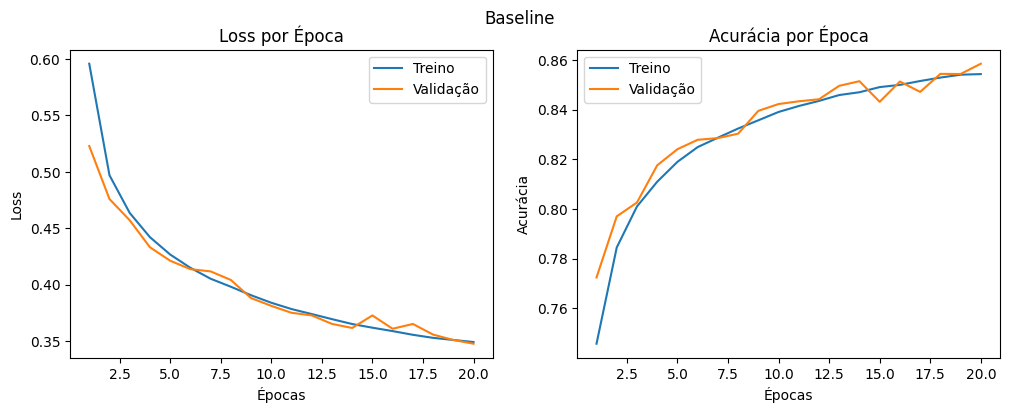

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

           0      0.866     0.831     0.848     31776
           1      0.858     0.658     0.745       412
           2      0.881     0.866     0.873      3077
           3      0.859     0.902     0.880     42495
           4      0.851     0.839     0.845      5363
           5      0.693     0.712     0.702      2605
           6      0.846     0.421     0.563      1424

    accuracy                          0.856     87152
   macro avg      0.836     0.747     0.779     87152
weighted avg      0.857     0.856     0.855     87152

[[26407     0   326  5002     3    14    24]
 [    0   271     0     0    92    49     0]
 [  383     0  2664    30     0     0     0]
 [ 3610     0    34 38345   177   246    83]
 [    2    31     0   325  4498   506     1]
 [   20    14     0   249   467  1854     1]
 [   61     0     0   706    51     6   600]]


In [ ]:
# Função de plot das curvas
def plot_learning_curves(history, title='Curvas de Aprendizagem'):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['loss'], label='Treino')
    plt.plot(epochs, history.history['val_loss'], label='Validação')
    plt.title('Loss por Época')
    plt.xlabel('Épocas'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['accuracy'], label='Treino')
    plt.plot(epochs, history.history['val_accuracy'], label='Validação')
    plt.title('Acurácia por Época')
    plt.xlabel('Épocas'); plt.ylabel('Acurácia'); plt.legend()
    plt.suptitle(title)
    plt.show()

# Plotar curvas do baseline
plot_learning_curves(history_baseline, 'Baseline')

# Avaliação no conjunto de teste
test_preds = np.argmax(baseline_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, test_preds, digits=3))
print(confusion_matrix(y_test_encoded, test_preds))

Esse resultado mostra que o modelo baseline treinado está apresentando um desempenho bom e estável, mas sofre com dificuldade em prever classes minoritárias (o que já era esperado pelo desbalanceamento).

A maior parte dos acertos está concentrada na classe 0 (Lodgepole Pine), que domina os dados.

Algumas classes raras como 1, 2, 6 têm muitos falsos negativos, ou seja, o modelo erra bastante ao tentar reconhecê-las.

**Loss por Época:**

Tanto a curva de treino quanto a de validação diminuem continuamente, indicando que o modelo está aprendendo.

A perda não diverge entre treino e validação, o que sugere que não há overfitting significativo.

Acurácia por Época:
**texto en negrita**
A acurácia sobe de forma consistente até ~86%, em ambos os conjuntos.

O modelo está generalizando bem para os dados de validação.


Estabilidade: não há grandes saltos ou oscilações abruptas, o que sugere que a taxa de aprendizado e o tamanho do lote estão adequados. As pequenas variações na val_loss e val_accuracy nas épocas finais são normais e não indicam overfitting.

Confirmação do comportamento: o relatório não mostra nenhum sinal de overfitting (como precision 100% e recall muito baixo ou vice-versa). As métricas são consistentes com as curvas de perda/ acurácia: há melhorias contínuas, mas não há grandes discrepâncias entre treino e teste.



# **Experimentos com hiperparâmetros**

**1. Rede mas profunda (128→64→32 neurônios, ReLU)**

Epoch 1/30
3178/3178 - 12s - 4ms/step - accuracy: 0.7669 - loss: 0.5490 - val_accuracy: 0.8102 - val_loss: 0.4536
Epoch 2/30
3178/3178 - 10s - 3ms/step - accuracy: 0.8194 - loss: 0.4267 - val_accuracy: 0.8299 - val_loss: 0.4051
Epoch 3/30
3178/3178 - 10s - 3ms/step - accuracy: 0.8402 - loss: 0.3834 - val_accuracy: 0.8444 - val_loss: 0.3729
Epoch 4/30
3178/3178 - 8s - 3ms/step - accuracy: 0.8530 - loss: 0.3546 - val_accuracy: 0.8614 - val_loss: 0.3445
Epoch 5/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8623 - loss: 0.3353 - val_accuracy: 0.8637 - val_loss: 0.3333
Epoch 6/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8689 - loss: 0.3196 - val_accuracy: 0.8671 - val_loss: 0.3285
Epoch 7/30
3178/3178 - 11s - 3ms/step - accuracy: 0.8739 - loss: 0.3082 - val_accuracy: 0.8629 - val_loss: 0.3267
Epoch 8/30
3178/3178 - 10s - 3ms/step - accuracy: 0.8773 - loss: 0.2997 - val_accuracy: 0.8811 - val_loss: 0.2992
Epoch 9/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8812 - loss: 0.2908 - val_accuracy: 0.88

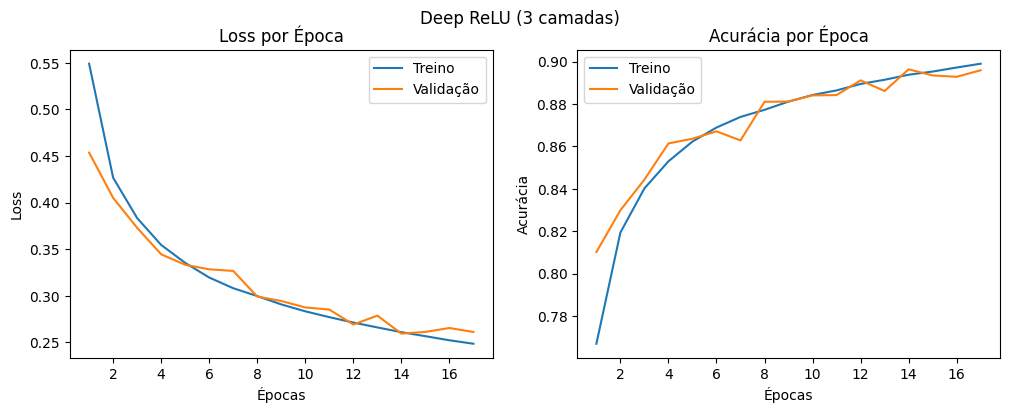

In [ ]:
def build_deep_relu_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

deep_relu_model = build_deep_relu_model()
history_deep_relu = deep_relu_model.fit(
    X_train, y_train_encoded, # Use encoded y_train
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val_encoded), # Use encoded y_val
    callbacks=[early_stop],
    verbose=2
)

# Avaliação
test_preds_deep_relu = np.argmax(deep_relu_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, test_preds_deep_relu, digits=3))
plot_learning_curves(history_deep_relu, 'Deep ReLU (3 camadas)')

O modelo melhorou em todas as métricas, especialmente em recall e F1-score nas classes minoritárias:

Classe 1 (Cottonwood/Willow): F1 passou de 0.745 → 0.766

Classe 6 (Aspen): F1 passou de 0.563 → 0.744

Isso mostra que a rede mais profunda consegue aprender melhor os padrões das classes menos representadas, que eram um desafio no modelo anterior.

**2. Função de ativação diferente (tanh)**

Epoch 1/30
3178/3178 - 11s - 3ms/step - accuracy: 0.7617 - loss: 0.5625 - val_accuracy: 0.8010 - val_loss: 0.4741
Epoch 2/30
3178/3178 - 11s - 3ms/step - accuracy: 0.8178 - loss: 0.4334 - val_accuracy: 0.8344 - val_loss: 0.3999
Epoch 3/30
3178/3178 - 20s - 6ms/step - accuracy: 0.8435 - loss: 0.3783 - val_accuracy: 0.8496 - val_loss: 0.3655
Epoch 4/30
3178/3178 - 19s - 6ms/step - accuracy: 0.8586 - loss: 0.3443 - val_accuracy: 0.8619 - val_loss: 0.3374
Epoch 5/30
3178/3178 - 11s - 3ms/step - accuracy: 0.8700 - loss: 0.3206 - val_accuracy: 0.8725 - val_loss: 0.3162
Epoch 6/30
3178/3178 - 10s - 3ms/step - accuracy: 0.8782 - loss: 0.3023 - val_accuracy: 0.8789 - val_loss: 0.2996
Epoch 7/30
3178/3178 - 10s - 3ms/step - accuracy: 0.8849 - loss: 0.2866 - val_accuracy: 0.8858 - val_loss: 0.2827
Epoch 8/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8907 - loss: 0.2737 - val_accuracy: 0.8879 - val_loss: 0.2781
Epoch 9/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8946 - loss: 0.2630 - val_accuracy: 0.

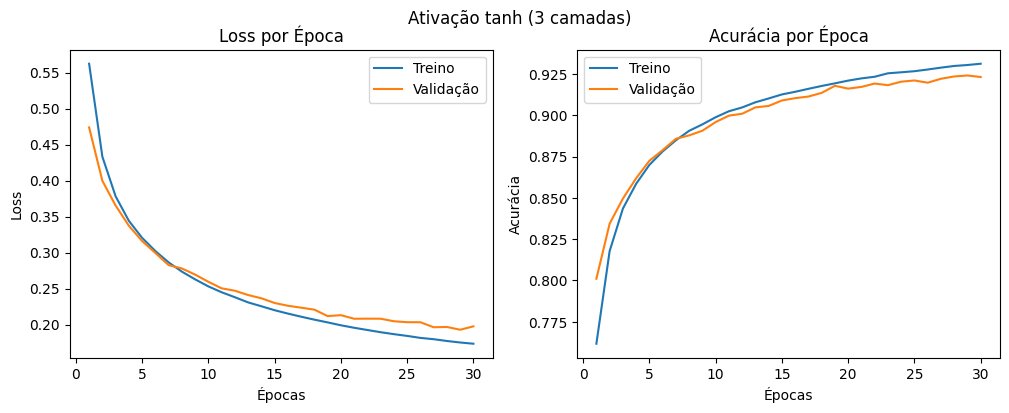

In [ ]:
def build_tanh_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tanh_model = build_tanh_model()
history_tanh = tanh_model.fit(
    X_train, y_train_encoded, # Use encoded y_train
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val_encoded), # Use encoded y_val
    callbacks=[early_stop],
    verbose=2
)

test_preds_tanh = np.argmax(tanh_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, test_preds_tanh, digits=3))
plot_learning_curves(history_tanh, 'Ativação tanh (3 camadas)')

Todas as métricas aumentaram, o que mostra que a função de ativação tanh ajudou a rede a capturar ainda melhor os padrões nos dados, especialmente nas classes minoritárias:

Classe 1 (Cottonwood/Willow): F1-score foi de 0.766 → 0.793

Classe 6 (Aspen): F1-score foi de 0.744 → 0.795



**4. Taxa de aprendizado diferente (learning_rate = 0,01)**

Epoch 1/30
3178/3178 - 9s - 3ms/step - accuracy: 0.7740 - loss: 0.5210 - val_accuracy: 0.8080 - val_loss: 0.4530
Epoch 2/30
3178/3178 - 8s - 3ms/step - accuracy: 0.8168 - loss: 0.4299 - val_accuracy: 0.8257 - val_loss: 0.4140
Epoch 3/30
3178/3178 - 10s - 3ms/step - accuracy: 0.8324 - loss: 0.3994 - val_accuracy: 0.8312 - val_loss: 0.4015
Epoch 4/30
3178/3178 - 7s - 2ms/step - accuracy: 0.8405 - loss: 0.3828 - val_accuracy: 0.8429 - val_loss: 0.3811
Epoch 5/30
3178/3178 - 8s - 3ms/step - accuracy: 0.8452 - loss: 0.3720 - val_accuracy: 0.8457 - val_loss: 0.3701
Epoch 6/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8486 - loss: 0.3644 - val_accuracy: 0.8529 - val_loss: 0.3599
Epoch 7/30
3178/3178 - 8s - 2ms/step - accuracy: 0.8515 - loss: 0.3584 - val_accuracy: 0.8531 - val_loss: 0.3586
Epoch 8/30
3178/3178 - 8s - 3ms/step - accuracy: 0.8546 - loss: 0.3523 - val_accuracy: 0.8559 - val_loss: 0.3504
Epoch 9/30
3178/3178 - 9s - 3ms/step - accuracy: 0.8560 - loss: 0.3484 - val_accuracy: 0.8577 -

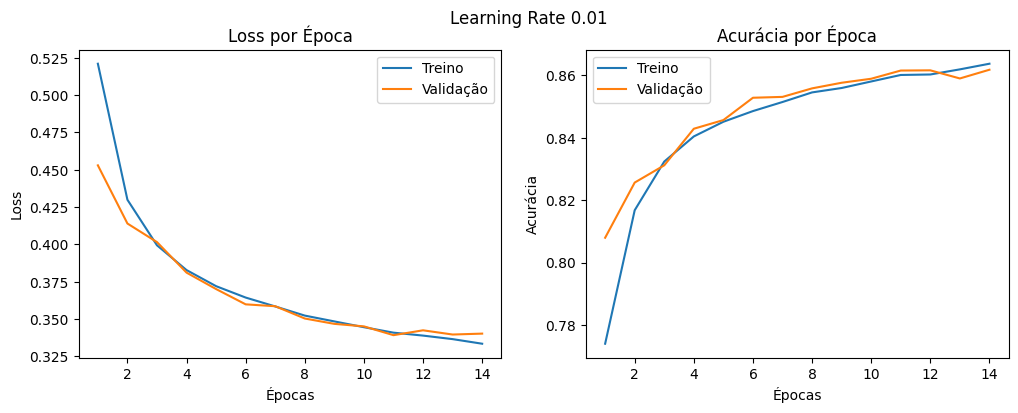

In [ ]:
def build_high_lr_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # taxa de aprendizado alta
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

high_lr_model = build_high_lr_model()
history_high_lr = high_lr_model.fit(
    X_train, y_train_encoded,
    epochs=30,
    batch_size=128,
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stop],
    verbose=2
)

test_preds_high_lr = np.argmax(high_lr_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, test_preds_high_lr, digits=3))
plot_learning_curves(history_high_lr, 'Learning Rate 0.01')

 O desempenho caiu com o aumento da learning rate, especialmente nas classes minoritárias:

Classe 1: F1-score caiu de 0.793 (com tanh) para 0.665

Classe 6: F1 caiu de 0.795 para 0.621

Ao aumentar a taxa de aprendizado para 0,01, o treinamento se tornou mais rápido nas primeiras épocas, mas o desempenho final foi inferior.

**5. Tamanho de batch maior e mais épocas**

o batch de 512 foi testado por ser uma escolha técnica comum e computacionalmente eficiente, mas seus resultados mostraram que ele não melhora o desempenho nesse caso específico.

Epoch 1/40
795/795 - 4s - 5ms/step - accuracy: 0.7129 - loss: 0.6986 - val_accuracy: 0.7579 - val_loss: 0.5696
Epoch 2/40
795/795 - 4s - 5ms/step - accuracy: 0.7673 - loss: 0.5394 - val_accuracy: 0.7674 - val_loss: 0.5299
Epoch 3/40
795/795 - 4s - 5ms/step - accuracy: 0.7834 - loss: 0.5014 - val_accuracy: 0.7856 - val_loss: 0.4923
Epoch 4/40
795/795 - 5s - 6ms/step - accuracy: 0.7956 - loss: 0.4762 - val_accuracy: 0.7997 - val_loss: 0.4692
Epoch 5/40
795/795 - 5s - 6ms/step - accuracy: 0.8040 - loss: 0.4583 - val_accuracy: 0.8114 - val_loss: 0.4511
Epoch 6/40
795/795 - 5s - 6ms/step - accuracy: 0.8110 - loss: 0.4442 - val_accuracy: 0.8163 - val_loss: 0.4378
Epoch 7/40
795/795 - 6s - 7ms/step - accuracy: 0.8162 - loss: 0.4327 - val_accuracy: 0.8188 - val_loss: 0.4324
Epoch 8/40
795/795 - 3s - 3ms/step - accuracy: 0.8206 - loss: 0.4238 - val_accuracy: 0.8218 - val_loss: 0.4245
Epoch 9/40
795/795 - 5s - 6ms/step - accuracy: 0.8239 - loss: 0.4167 - val_accuracy: 0.8262 - val_loss: 0.4141
E

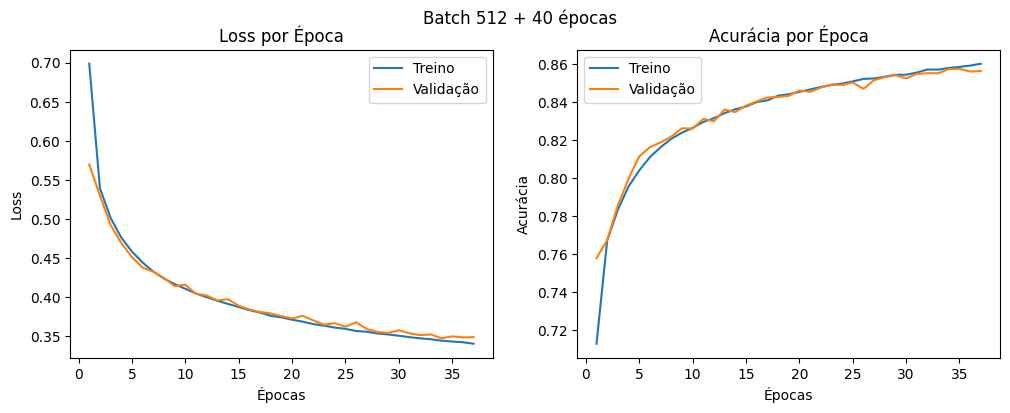

In [ ]:
def build_large_batch_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

large_batch_model = build_large_batch_model()
history_large_batch = large_batch_model.fit(
    X_train, y_train_encoded,
    epochs=40,             # número maior de épocas
    batch_size=512,        # batch size maior
    validation_data=(X_val, y_val_encoded),
    callbacks=[early_stop],
    verbose=2
)

test_preds_large_batch = np.argmax(large_batch_model.predict(X_test), axis=1)
print(classification_report(y_test_encoded, test_preds_large_batch, digits=3))
plot_learning_curves(history_large_batch, 'Batch 512 + 40 épocas')

A utilização de um tamanho de batch maior (512) e aumento no número de épocas (40) resultou em curvas de aprendizagem mais suaves e treinamento estável. No entanto, o desempenho final não superou configurações anteriores

Acurácia: 0.856 → igual à do baseline (com batch menor).

F1-score (macro): 0.775 → abaixo da versão com função tanh e 3 camadas (que teve 0.873).

Classe 6, por exemplo, segue com F1-score muito baixo (0.587), indicando dificuldade com classes minoritárias.

O desempenho geral não melhorou, mesmo com mais tempo de treinamento.

**Comparando os resultados**

In [ ]:
import pandas as pd

reports = {
    'baseline': classification_report(y_test_encoded, baseline_model.predict(X_test).argmax(axis=1), output_dict=True),
    'deep_relu': classification_report(y_test_encoded, test_preds_deep_relu, output_dict=True),
    'tanh': classification_report(y_test_encoded, test_preds_tanh, output_dict=True),
    'lr_0.01': classification_report(y_test_encoded, test_preds_high_lr, output_dict=True),
    'batch_512': classification_report(y_test_encoded, test_preds_large_batch, output_dict=True),
}

summary = pd.DataFrame({
    name: {
        'accuracy': rep['accuracy'],
        'macro_f1': sum(rep[str(i)]['f1-score'] for i in range(7))/7 # Note: class labels are 0-6 for encoded data
    }
    for name, rep in reports.items()
}).T

display(summary)

2724/2724 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


,accuracy,macro_f1
baseline,0.856423,0.779362
deep_relu,0.895252,0.838836
tanh,0.924752,0.873397
lr_0.01,0.860979,0.770795
batch_512,0.856010,0.775239


# **Conclusões**

Neste projeto, testamos diferentes configurações de redes neurais MLP aplicadas ao problema de classificação de cobertura vegetal, utilizando o conjunto de dados do UCI (Covertype). Os experimentos variaram número de camadas, funções de ativação, taxa de aprendizado, tamanho de batch e número de épocas, permitindo observar como cada hiperparâmetro impacta o desempenho do modelo.

-A rede baseline (2 camadas ocultas, ReLU, LR=0.001, 20 épocas) já apresentou bom desempenho inicial, com acurácia de 0.856 e F1-score macro de 0.747, mas mostrou limitações com classes minoritárias.

-Ao aprofundar a rede (3 camadas) mantendo a ReLU, houve ganho relevante: acurácia subiu para 0.895 e F1-score macro para 0.839, indicando que a profundidade melhorou a capacidade de generalização.

-A substituição da função de ativação por tanh trouxe os melhores resultados do experimento: acurácia de 0.925 e F1-score macro de 0.873, com curvas de aprendizagem mais consistentes e sem sinais de overfitting, mesmo com 30 épocas.

-Aumentar apenas a taxa de aprendizado (0.01) reduziu o tempo de convergência, mas também piorou o desempenho final (F1-score macro de 0.771), sugerindo que um passo muito grande nas atualizações pode comprometer a qualidade do ajuste.

-O uso de batch maior (512) e 40 épocas trouxe estabilidade às curvas, mas não resultou em melhoria significativa nas métricas, indicando que o modelo atingiu um limite com essa configuração.


De acordo com esses insigths,  profundidade e escolha da função de ativação são os fatores que mais impactaram positivamente a performance. As configurações com tanh e com rede mais profunda apresentaram os maiores ganhos, tanto em acurácia quanto em F1 macro, enquanto ajustes isolados na taxa de aprendizado ou tamanho do batch não trouxeram melhorias.